In [2]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import sys
sys.path.append("../src/")
sys.path.append("D:/metabolome_inference/metabolome_inference/src/")
from PeakDetective import rawData,PeakDetective,Classifier,Smoother,normalizeMatrix,safeNormalize
import detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import NeatMS as ntms
from copy import deepcopy

In [3]:
datadir = "../data/NIST/"
rawDataDir = datadir + "raw_data/"
resolution = 60

In [4]:
ms1ppm = 10
peakWidth = (10,85)
s2n = 5
noise = 100
det = detection_helper.PeakList()
#det.runXCMS(rawDataDir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
peakList["rt"] = .5 * peakList["rt_start"] + .5 * peakList["rt_end"]
peakList = peakList[["mz","rt"]]
peakList

,mz,rt
1,68.084575,0.903144
2,69.009349,0.821771
3,69.009343,13.699052
4,69.009343,14.196510
5,68.995698,0.965815
...,...,...
10288,896.688251,12.321862
10289,896.662404,8.147289
10290,897.707274,12.739011
10291,897.787089,9.544567


In [5]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv")
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mz","rt","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mz"].values - (ms1ppm * neatMSPeakList["mz"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mz"].values + (ms1ppm * neatMSPeakList["mz"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


,mz,rt,rtmin,rtmax,feature_id,sample,into,mzmin,mzmax,intb,maxo,sn,sample_name
0,68.084575,54.272102,41.630024,53.630024,0,NIST1950_neg_ID_01.mzML,1.121746e+06,68.083894,68.085255,1.121746e+06,1.121746e+06,10,NIST1950_neg_ID_01.mzML
1,69.009349,49.641574,36.053491,48.053491,1,NIST1950_neg_ID_01.mzML,4.396395e+06,69.008659,69.010039,4.396395e+06,4.396395e+06,10,NIST1950_neg_ID_01.mzML
2,69.009343,821.943145,809.943145,821.943145,2,NIST1950_neg_ID_01.mzML,1.274843e+05,69.008653,69.010033,1.274843e+05,1.274843e+05,10,NIST1950_neg_ID_01.mzML
3,69.009343,851.790617,839.790617,851.790617,3,NIST1950_neg_ID_01.mzML,3.760104e+05,69.008653,69.010033,3.760104e+05,3.760104e+05,10,NIST1950_neg_ID_01.mzML
4,68.995698,57.948913,45.948913,57.948913,4,NIST1950_neg_ID_01.mzML,3.504610e+05,68.995008,68.996388,3.504610e+05,3.504610e+05,10,NIST1950_neg_ID_01.mzML
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30871,896.688251,739.311741,727.311741,739.311741,10287,NIST1950_neg_ID_04.mzML,6.359928e+04,896.679284,896.697218,6.359928e+04,6.359928e+04,10,NIST1950_neg_ID_04.mzML
30872,896.662404,488.837344,476.837344,488.837344,10288,NIST1950_neg_ID_04.mzML,7.203653e+04,896.653437,896.671371,7.203653e+04,7.203653e+04,10,NIST1950_neg_ID_04.mzML
30873,897.707274,764.340641,751.999461,763.999461,10289,NIST1950_neg_ID_04.mzML,5.920523e+04,897.698297,897.716251,5.920523e+04,5.920523e+04,10,NIST1950_neg_ID_04.mzML
30874,897.787089,572.674027,560.674027,572.674027,10290,NIST1950_neg_ID_04.mzML,8.790525e+04,897.778112,897.796067,8.790525e+04,8.790525e+04,10,NIST1950_neg_ID_04.mzML


In [6]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(rawDataDir, feature_table_path, input_data)

In [10]:
pkl_file =  datadir + "NeatMS_nist.pkl"
import pickle
with open(pkl_file, 'rb') as f:
    experiment = pickle.load(f)

In [7]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [8]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)
nn_handler.get_model_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 120, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 120, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 60, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 60, 64)         18496     
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               983168    
                                                           

In [9]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

308/308 [==============================] - 2s 6ms/step


In [10]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

,feature ID,sample,m/z,retention time,height,area,label
0,0,NIST1950_neg_ID_01,68.084575,0.904535,1.121746e+06,1.121746e+06,High_quality
1,0,NIST1950_neg_ID_03,68.084575,0.904535,1.323590e+06,1.323590e+06,Noise
2,0,NIST1950_neg_ID_04,68.084575,0.904535,1.221669e+06,1.221669e+06,Noise
3,1,NIST1950_neg_ID_01,69.009349,0.827360,4.396395e+06,4.396395e+06,Noise
4,1,NIST1950_neg_ID_03,69.009349,0.827360,5.184098e+06,5.184098e+06,Noise
...,...,...,...,...,...,...,...
29451,10290,NIST1950_neg_ID_03,897.787089,9.544567,5.937995e+04,5.937995e+04,Low_quality
29452,10290,NIST1950_neg_ID_04,897.787089,9.544567,8.790525e+04,8.790525e+04,Low_quality
29453,10291,NIST1950_neg_ID_01,897.732226,10.801036,NaN,NaN,High_quality
29454,10291,NIST1950_neg_ID_03,897.732226,10.801036,3.747974e+04,3.747974e+04,Noise


In [13]:
files = [x for x in os.listdir(rawDataDir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = rawData()
    temp.readRawDataFile(rawDataDir + file,ms1ppm)
    raw_data.append(temp)

['NIST1950_neg_ID_01.mzML', 'NIST1950_neg_ID_03.mzML', 'NIST1950_neg_ID_04.mzML']


In [14]:
integ = PeakDetective(numCores = 20,resolution=resolution)

In [15]:
Smoother(resolution).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 reshape_3 (Reshape)         (None, 60, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 58, 32)            128       
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 16)            1552      
                                                                 
 conv1d_8 (Conv1D)           (None, 54, 8)             392       
                                                                 
 conv1d_9 (Conv1D)           (None, 52, 4)             100       
                                                                 
 flatten_3 (Flatten)         (None, 208)               0   

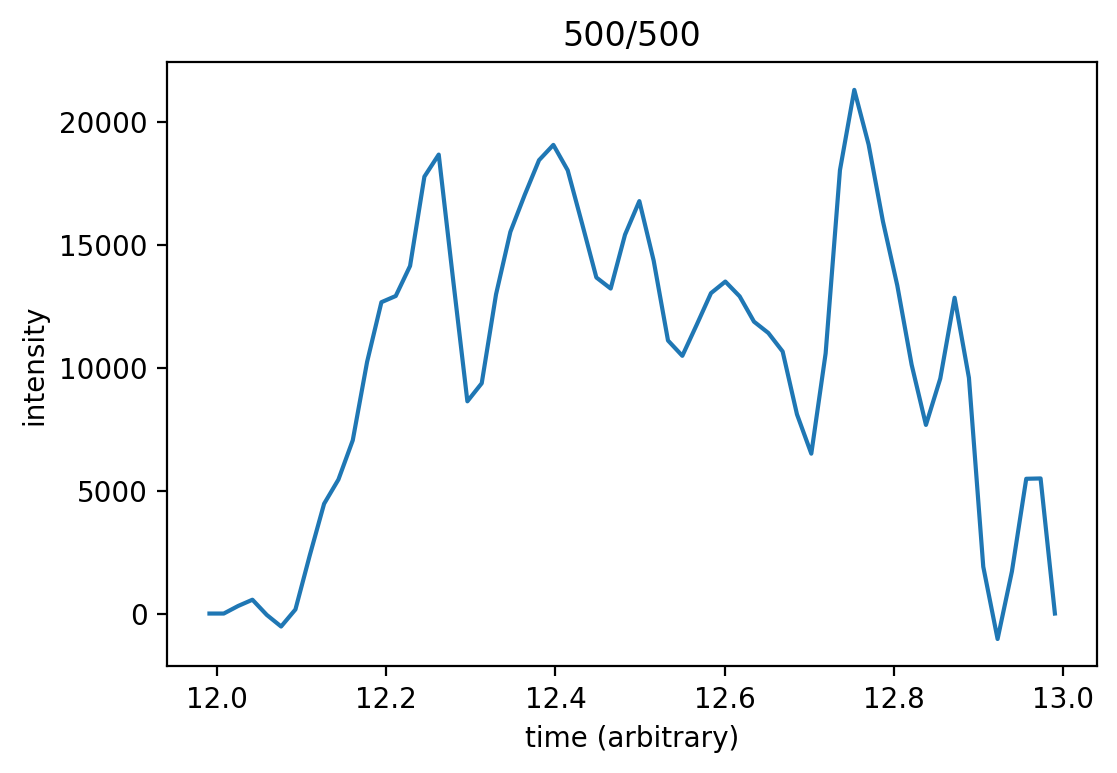

Enter classification (1=True Peak, 0=Artifact): 


 0


In [16]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)

In [17]:
peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [18]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [19]:
peakList_labeled

,mz,rt,classification
1552,134.865146,6.840321,0.0
66,74.990680,0.903144,1.0
420,92.006901,3.023998,0.0
2512,173.118210,0.835005,1.0
2544,174.956426,10.107568,0.0
...,...,...,...
8874,556.848995,10.699781,0.0
5815,307.001415,6.182090,1.0
322,89.042770,1.062223,1.0
9560,658.828502,11.983876,0.0


In [20]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

,feature ID,sample,m/z,retention time,height,area,label
0,0,NIST1950_neg_ID_01,68.084575,0.904535,1.121746e+06,1.121746e+06,High_quality
3,1,NIST1950_neg_ID_01,69.009349,0.827360,4.396395e+06,4.396395e+06,Noise
6,2,NIST1950_neg_ID_01,69.009343,13.699052,1.274843e+05,1.274843e+05,Noise
9,3,NIST1950_neg_ID_01,69.009343,14.196510,3.760104e+05,3.760104e+05,Noise
12,4,NIST1950_neg_ID_01,68.995698,0.965815,3.504610e+05,3.504610e+05,Low_quality
...,...,...,...,...,...,...,...
29441,10287,NIST1950_neg_ID_01,896.688251,12.321862,4.690073e+04,4.690073e+04,High_quality
29444,10288,NIST1950_neg_ID_01,896.662404,8.147289,2.021502e+04,2.021502e+04,Noise
29447,10289,NIST1950_neg_ID_01,897.707274,12.739011,8.267920e+04,8.267920e+04,Noise
29450,10290,NIST1950_neg_ID_01,897.787089,9.544567,7.860615e+04,7.860615e+04,Low_quality


In [21]:
matchIDs = {}
for index,row in peakList_labeled.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

220


In [22]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
6984,2511,NIST1950_neg_ID_01,173.118210,0.834282,1.970746e+07,1.970746e+07,Noise,0.0
7077,2543,NIST1950_neg_ID_01,174.956426,10.107568,1.255482e+09,1.255482e+09,Noise,0.0
21605,7624,NIST1950_neg_ID_01,419.821694,13.181471,4.600539e+04,4.600539e+04,Noise,0.0
22902,8068,NIST1950_neg_ID_01,459.343486,12.354779,8.532760e+04,8.532760e+04,Noise,0.0
26196,9187,NIST1950_neg_ID_01,595.817621,12.763840,3.454424e+05,3.454424e+05,Noise,0.0
...,...,...,...,...,...,...,...,...
22154,7810,NIST1950_neg_ID_01,435.251593,1.144449,1.327023e+05,1.327023e+05,Noise,0.0
6070,2188,NIST1950_neg_ID_01,159.950501,3.126382,1.604189e+04,1.604189e+04,High_quality,1.0
25269,8873,NIST1950_neg_ID_01,556.848995,10.699781,7.024736e+05,7.024736e+05,Noise,0.0
16350,5814,NIST1950_neg_ID_01,307.001415,6.187386,8.555102e+04,8.555102e+04,Noise,0.0


In [23]:
true_neatms = peakList_labeled.loc[order,"classification"].values
pred_neatms = filt["classification"].values
print(len(true_neatms),confusion_matrix(true_neatms,pred_neatms))
met.accuracy_score(true_neatms,pred_neatms)

220 [[133  12]
 [ 63  12]]


0.6590909090909091

In [24]:
annotation_tool = ntms.AnnotationTool(experiment)
annotation_tool.launch_annotation_tool()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:175: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:176: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [30]:
annotation_table = experiment.feature_tables[0].annotation_table
print("Total number of annotated peaks:",len(annotation_table.labelled_peaks))
for annotation in annotation_table.annotations:
    print(annotation.label,len(annotation.peaks))

Total number of annotated peaks: 200
High_quality 34
Low_quality 27
Noise 139


In [31]:
experiment.name = '../data/neatms/NeatMS_covid_data'
experiment.save()

In [32]:
# Let's freeze the convolutional base
# We can do that by selecting layers using their names

layer_names = ['conv2d_1','conv2d_2','max_pooling2d_1']
for layer_name in layer_names:
    nn_handler.class_model.get_layer(layer_name).trainable = False

# Here is how to make sure that the right layers are still trainable
for layer in nn_handler.class_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000263EE1A64C8> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000263EE005288> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000263EE005D08> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000263EDFE3348> False
<keras.layers.reshaping.flatten.Flatten object at 0x00000263EDFE3D08> True
<keras.layers.core.dense.Dense object at 0x00000263EF0BE308> True
<keras.layers.regularization.dropout.Dropout object at 0x00000263EF0BEC48> True
<keras.layers.core.dense.Dense object at 0x00000263EF0AF288> True


In [33]:
from keras.optimizers import SGD, Adam 
lr = 0.00001
opt = Adam(lr=lr)
nn_handler.class_model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy','mae'])

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [34]:
nn_handler.create_batches(validation_split=0.1, normalise_class=False)

In [35]:
nn_handler.train_model(20)

Epoch 1/20
5/5 [==============================] - 1s 89ms/step - loss: 1.6988 - accuracy: 0.6258 - mae: 0.2559 - val_loss: 2.4825 - val_accuracy: 0.4737 - val_mae: 0.3239
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 1.6319 - accuracy: 0.6194 - mae: 0.2532 - val_loss: 2.4057 - val_accuracy: 0.4737 - val_mae: 0.3271
Epoch 3/20
5/5 [==============================] - 0s 19ms/step - loss: 1.5640 - accuracy: 0.6129 - mae: 0.2530 - val_loss: 2.3373 - val_accuracy: 0.4737 - val_mae: 0.3292
Epoch 4/20
5/5 [==============================] - 0s 19ms/step - loss: 1.5820 - accuracy: 0.6194 - mae: 0.2589 - val_loss: 2.2740 - val_accuracy: 0.4737 - val_mae: 0.3306
Epoch 5/20
5/5 [==============================] - 0s 19ms/step - loss: 1.5775 - accuracy: 0.6258 - mae: 0.2588 - val_loss: 2.2150 - val_accuracy: 0.4737 - val_mae: 0.3315
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 1.4968 - accuracy: 0.6129 - mae: 0.2631 - val_loss: 2.1596 - val_accuracy:

In [36]:
nn_handler.class_model.save(datadir + "covid_model_tl.h5")

In [37]:
# Set the threshold to 0.22
threshold=0.22

# Run the prediction
nn_handler.predict_peaks(threshold)

308/308 [==============================] - 2s 8ms/step


In [38]:
# We create the dataframe using this function
NeatMS_output_df_tl = experiment.export_to_dataframe()
# And display it
NeatMS_output_df_tl

,feature ID,sample,m/z,retention time,height,area,label
0,0,NIST1950_neg_ID_01,68.084575,0.904535,1.121746e+06,1.121746e+06,High_quality
1,0,NIST1950_neg_ID_03,68.084575,0.904535,1.323590e+06,1.323590e+06,High_quality
2,0,NIST1950_neg_ID_04,68.084575,0.904535,1.221669e+06,1.221669e+06,High_quality
3,1,NIST1950_neg_ID_01,69.009349,0.827360,4.396395e+06,4.396395e+06,High_quality
4,1,NIST1950_neg_ID_03,69.009349,0.827360,5.184098e+06,5.184098e+06,Low_quality
...,...,...,...,...,...,...,...
29451,10290,NIST1950_neg_ID_03,897.787089,9.544567,5.937995e+04,5.937995e+04,Low_quality
29452,10290,NIST1950_neg_ID_04,897.787089,9.544567,8.790525e+04,8.790525e+04,High_quality
29453,10291,NIST1950_neg_ID_01,897.732226,10.801036,NaN,NaN,High_quality
29454,10291,NIST1950_neg_ID_03,897.732226,10.801036,3.747974e+04,3.747974e+04,High_quality


In [39]:
filt = NeatMS_output_df_tl[NeatMS_output_df_tl["sample"] == files[0].replace(".mzML","")]
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
6984,2511,NIST1950_neg_ID_01,173.118210,0.834282,1.970746e+07,1.970746e+07,High_quality,1.0
7077,2543,NIST1950_neg_ID_01,174.956426,10.107568,1.255482e+09,1.255482e+09,Noise,0.0
21605,7624,NIST1950_neg_ID_01,419.821694,13.181471,4.600539e+04,4.600539e+04,Noise,0.0
22902,8068,NIST1950_neg_ID_01,459.343486,12.354779,8.532760e+04,8.532760e+04,High_quality,1.0
26196,9187,NIST1950_neg_ID_01,595.817621,12.763840,3.454424e+05,3.454424e+05,Noise,0.0
...,...,...,...,...,...,...,...,...
22154,7810,NIST1950_neg_ID_01,435.251593,1.144449,1.327023e+05,1.327023e+05,High_quality,1.0
6070,2188,NIST1950_neg_ID_01,159.950501,3.126382,1.604189e+04,1.604189e+04,High_quality,1.0
25269,8873,NIST1950_neg_ID_01,556.848995,10.699781,7.024736e+05,7.024736e+05,Noise,0.0
16350,5814,NIST1950_neg_ID_01,307.001415,6.187386,8.555102e+04,8.555102e+04,High_quality,1.0


In [40]:
true_neatms_tl = peakList_labeled.loc[order,"classification"].values
pred_neatms_tl = filt["classification"].values
print(len(true_neatms_tl),confusion_matrix(true_neatms_tl,pred_neatms_tl))
met.accuracy_score(true_neatms_tl,pred_neatms_tl)

220 [[120  25]
 [ 38  37]]


0.7136363636363636

In [41]:
peakList

,mz,rt
1,68.084575,0.903144
2,69.009349,0.821771
3,69.009343,13.699052
4,69.009343,14.196510
5,68.995698,0.965815
...,...,...
10288,896.688251,12.321862
10289,896.662404,8.147289
10290,897.707274,12.739011
10291,897.787089,9.544567


Epoch 1/30
484/484 [==============================] - 3s 4ms/step - loss: 0.4328 - mean_absolute_error: 0.2701 - val_loss: 0.1082 - val_mean_absolute_error: 0.0340
Epoch 2/30
484/484 [==============================] - 2s 4ms/step - loss: 0.0778 - mean_absolute_error: 0.0193 - val_loss: 0.0795 - val_mean_absolute_error: 0.0276
Epoch 3/30
484/484 [==============================] - 2s 4ms/step - loss: 0.0581 - mean_absolute_error: 0.0165 - val_loss: 0.0874 - val_mean_absolute_error: 0.0360
Epoch 4/30
484/484 [==============================] - 2s 4ms/step - loss: 0.0486 - mean_absolute_error: 0.0151 - val_loss: 0.0918 - val_mean_absolute_error: 0.0366
Epoch 5/30
484/484 [==============================] - 2s 4ms/step - loss: 0.0432 - mean_absolute_error: 0.0143 - val_loss: 0.1302 - val_mean_absolute_error: 0.0754
Epoch 5: early stopping
897/897 [==============================] - 1s 1ms/step


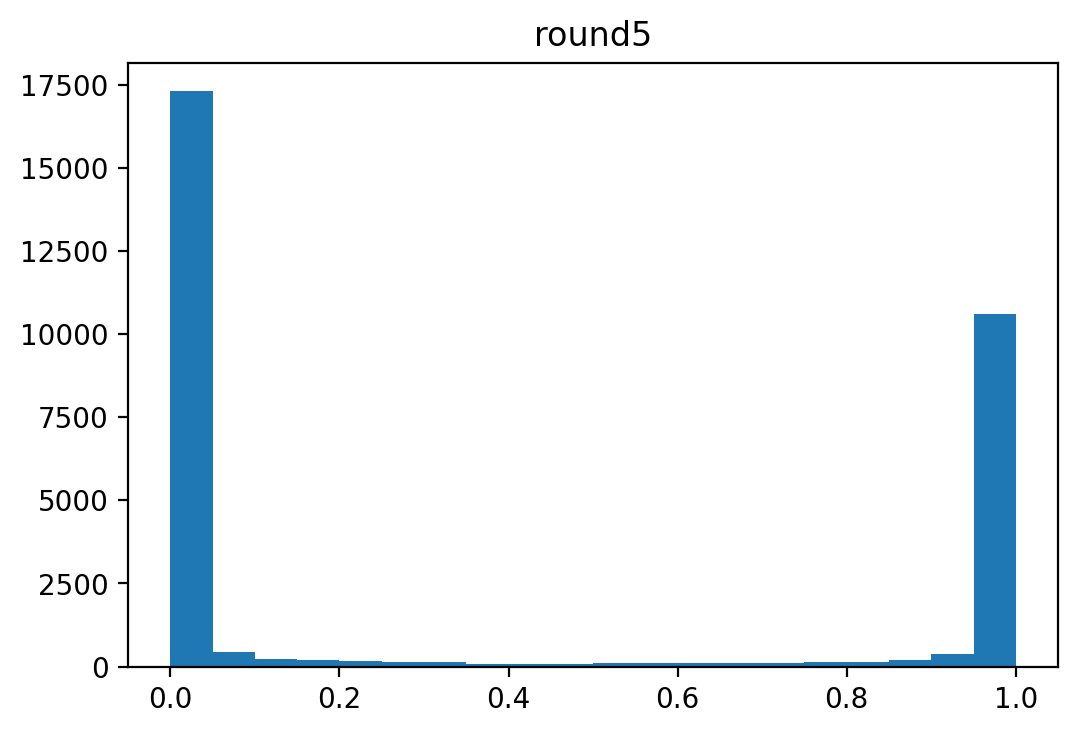

28688 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


965/965 [==============================] - 1s 1ms/step
done
formatting output...

In [42]:
# format X
if __name__ == "__main__":
    ms1_peaks_curated,X_norm,X_orig,tics,scores,progress,peak_scores,performance,peak_intensities = integ.curatePeaks(raw_data,peakList,
                                                                                min_peaks=50000,shift=7.0,
                                                                                smooth_epochs=20,class_epochs=30,
                                                                                threshold=0.5,useSynthetic=True,
                                                                                numManualPerRound=10,validation_split=0.1,
                                                                                autoClassify = False,noise=500)

In [43]:
ms1_peaks_curated

{'../data/NIST/raw_data/NIST1950_neg_ID_01.mzML':                mz         rt
 1       68.084575   0.903144
 5       68.995698   0.965815
 30      70.945975   5.141205
 33      71.013744   1.523133
 34      71.050151   1.157119
 ...           ...        ...
 10283  890.733277   8.606332
 10285  894.691611  12.465400
 10286  894.720642  11.257127
 10287  895.364829  12.735212
 10290  897.707274  12.739011
 
 [3957 rows x 2 columns],
 '../data/NIST/raw_data/NIST1950_neg_ID_03.mzML':                mz         rt
 1       68.084575   0.903144
 5       68.995698   0.965815
 30      70.945975   5.141205
 33      71.013744   1.523133
 34      71.050151   1.157119
 ...           ...        ...
 10263  877.752024  10.449547
 10264  878.702977   8.542438
 10283  890.733277   8.606332
 10287  895.364829  12.735212
 10290  897.707274  12.739011
 
 [4054 rows x 2 columns],
 '../data/NIST/raw_data/NIST1950_neg_ID_04.mzML':                mz         rt
 1       68.084575   0.903144
 5       68.99569

[28738, 28728, 28718, 28708, 28698]


Text(0, 0.5, 'log10(# of uncertain peaks)')

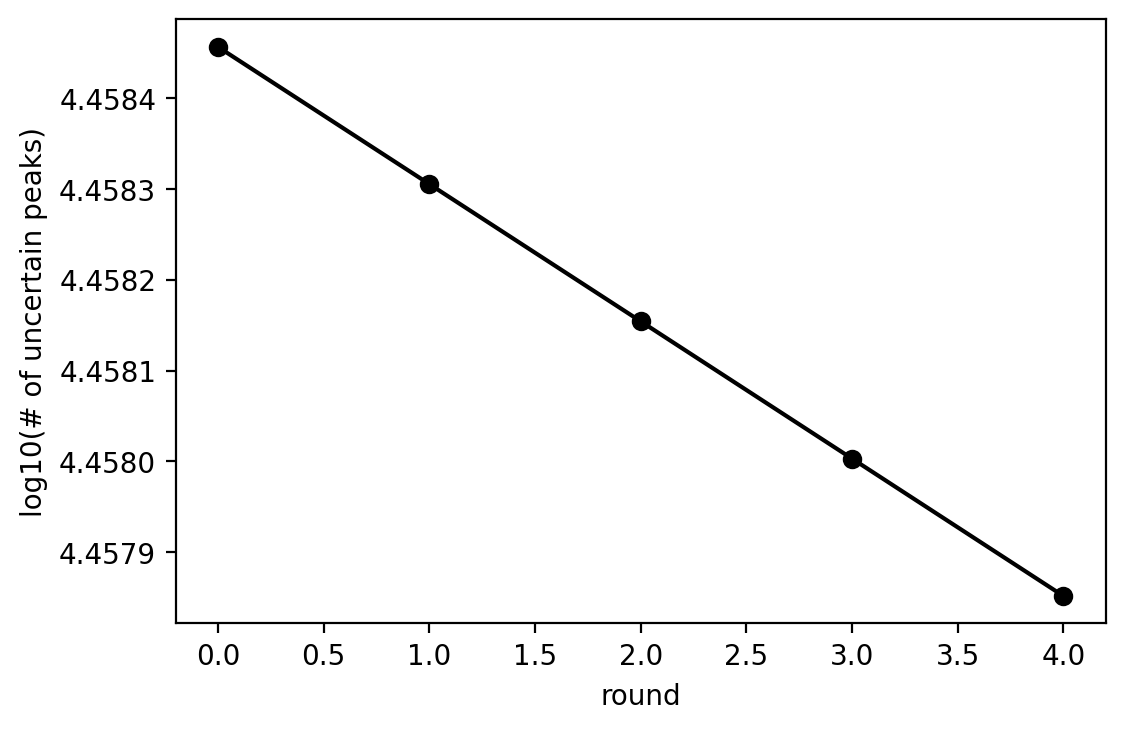

In [44]:
print(progress)
plt.plot(list(range(len(progress))),np.log10(progress),color="black")
plt.scatter(list(range(len(progress))),np.log10(progress),color="black")
plt.xlabel("round")
plt.ylabel("log10(# of uncertain peaks)")

Text(0, 0.5, 'validation mean absolute error')

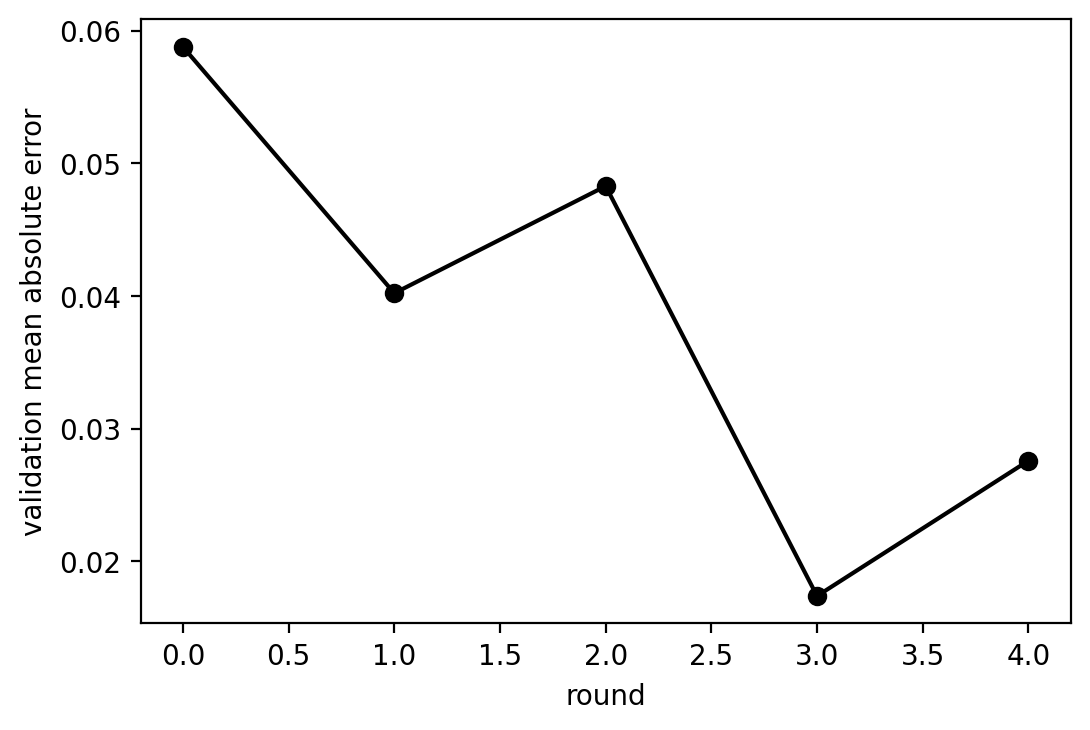

In [45]:
print()
plt.plot(list(range(len(performance))),performance,color="black")
plt.scatter(list(range(len(performance))),performance,color="black")
plt.xlabel("round")
plt.ylabel("validation mean absolute error")

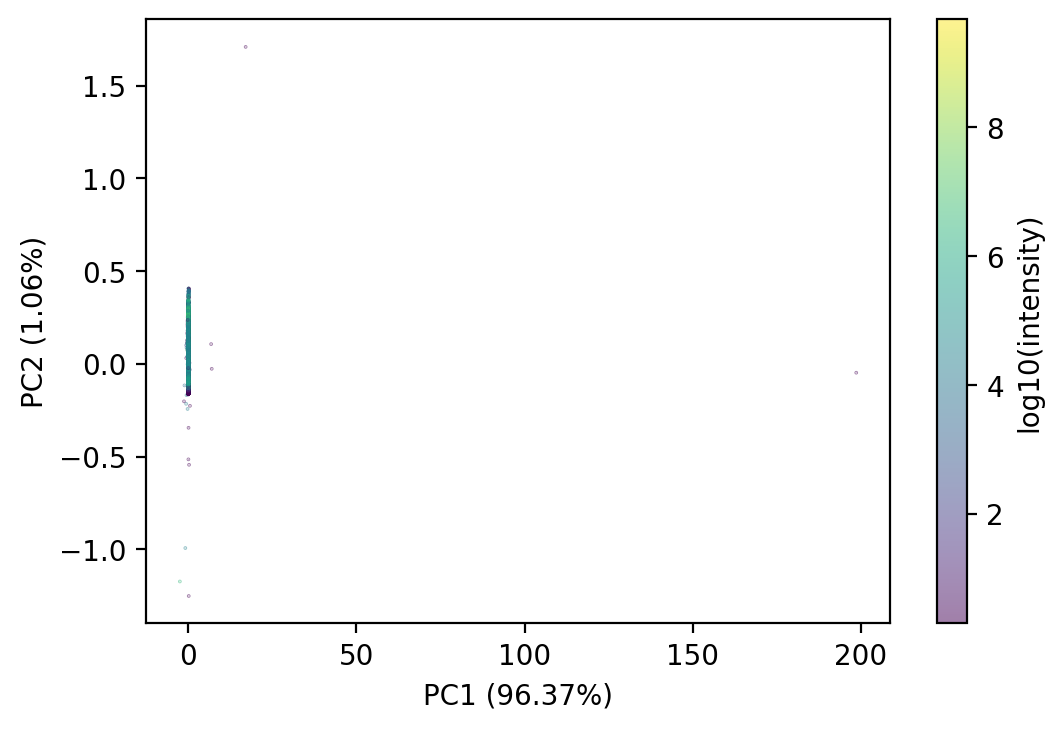

In [47]:
pca = PCA(2)
loads = pca.fit_transform(X_orig)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

(-1.0, 100.0)

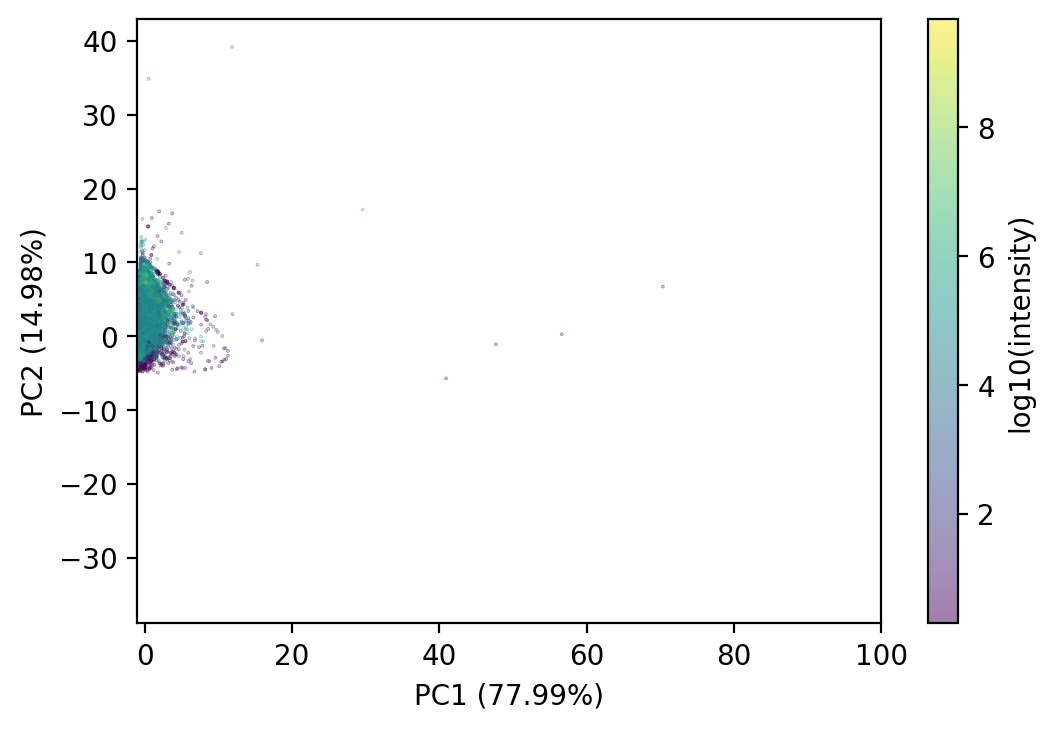

In [51]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")
plt.xlim((-1,100))

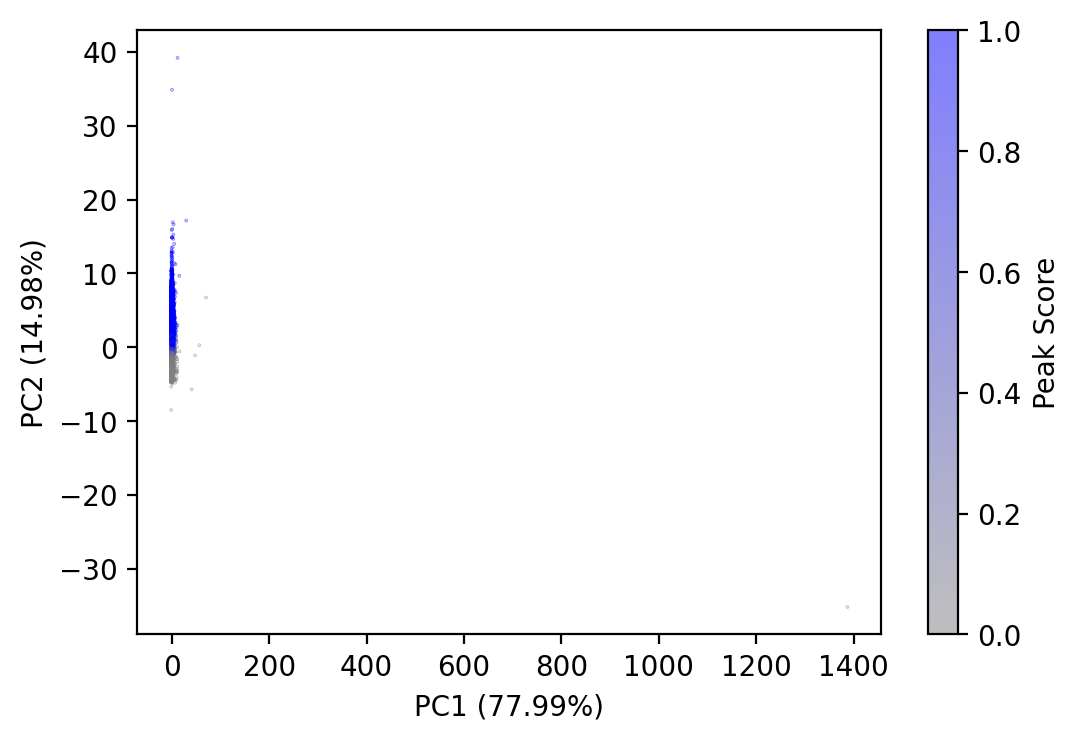

In [53]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=scores,s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="Peak Score")

Text(0, 0.5, '% of features')

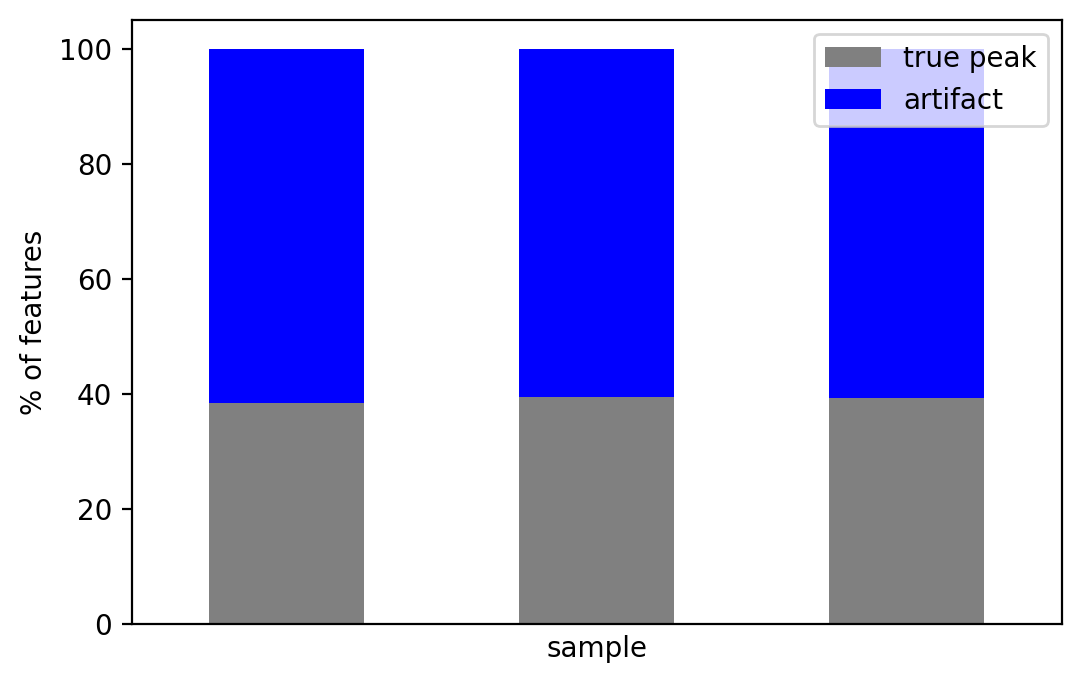

In [55]:
df = {}
for file in files:
    for index,row in peakList.iterrows():
        if index in ms1_peaks_curated[rawDataDir + file].index.values:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['NIST1950_neg_ID_01.mzML', 'NIST1950_neg_ID_03.mzML', 'NIST1950_neg_ID_04.mzML']


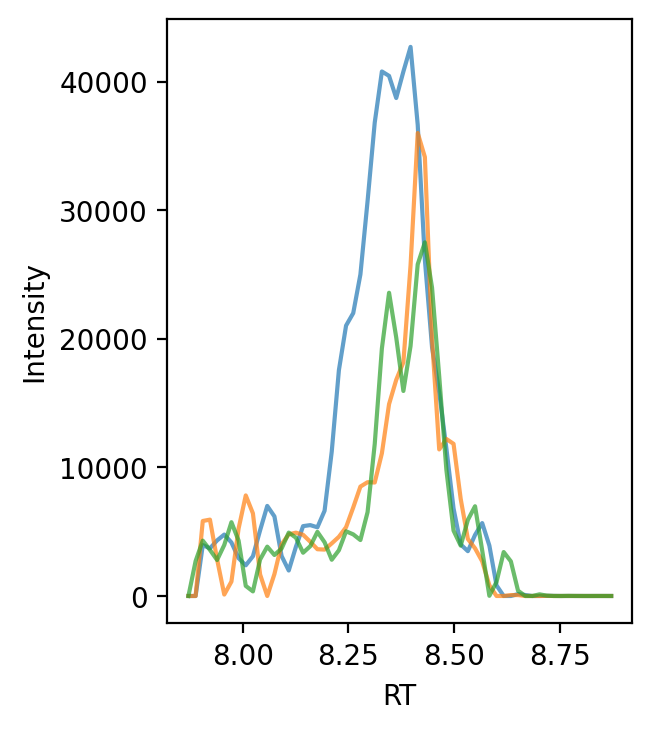

In [61]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = rawDataDir + files[0]
print(files)
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if i in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,ms1_peaks_curated[file].at[i,"mz"],ms1_peaks_curated[file].at[i,"rt"]-.5,ms1_peaks_curated[file].at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

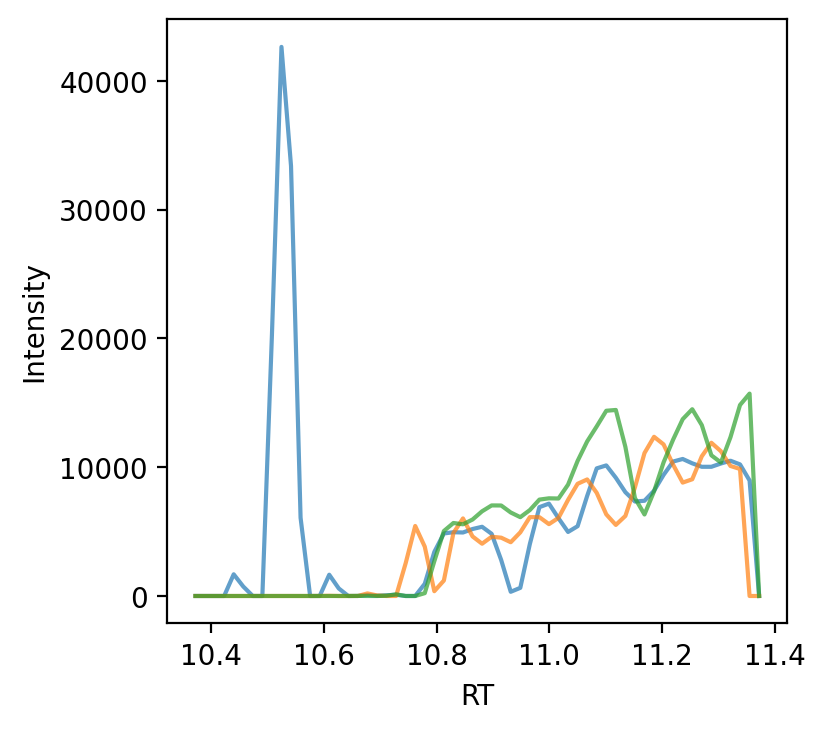

In [62]:
file = rawDataDir + files[0]
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(4,4))

for i in inds:
    if i not in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,peakList.at[i,"mz"],peakList.at[i,"rt"]-.5,peakList.at[i,"rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [64]:
true = []
pred = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    if index in order:
        if index in ms1_peaks_curated[rawDataDir + file].index.values:
            pred.append(1.0)
        else:
            pred.append(0.0)
        true.append(row["classification"])
print(len(true),confusion_matrix(true,pred))
met.accuracy_score(true,pred)

220 [[120  25]
 [ 13  62]]


0.8272727272727273

In [65]:
peak_scores

,mz,rt,../data/NIST/raw_data/NIST1950_neg_ID_01.mzML,../data/NIST/raw_data/NIST1950_neg_ID_03.mzML,../data/NIST/raw_data/NIST1950_neg_ID_04.mzML
1,68.084575,0.903144,1.000000,0.999356,0.999467
2,69.009349,0.821771,0.000000,0.045192,0.137693
3,69.009343,13.699052,0.000000,0.000129,0.000110
4,69.009343,14.196510,0.000000,0.000166,0.000158
5,68.995698,0.965815,1.000000,0.997590,0.996173
...,...,...,...,...,...
10288,896.688251,12.321862,0.001272,0.000000,0.998398
10289,896.662404,8.147289,0.000000,0.011889,0.763383
10290,897.707274,12.739011,0.997981,0.882023,0.996314
10291,897.787089,9.544567,0.001398,0.001929,0.021998


0.4732

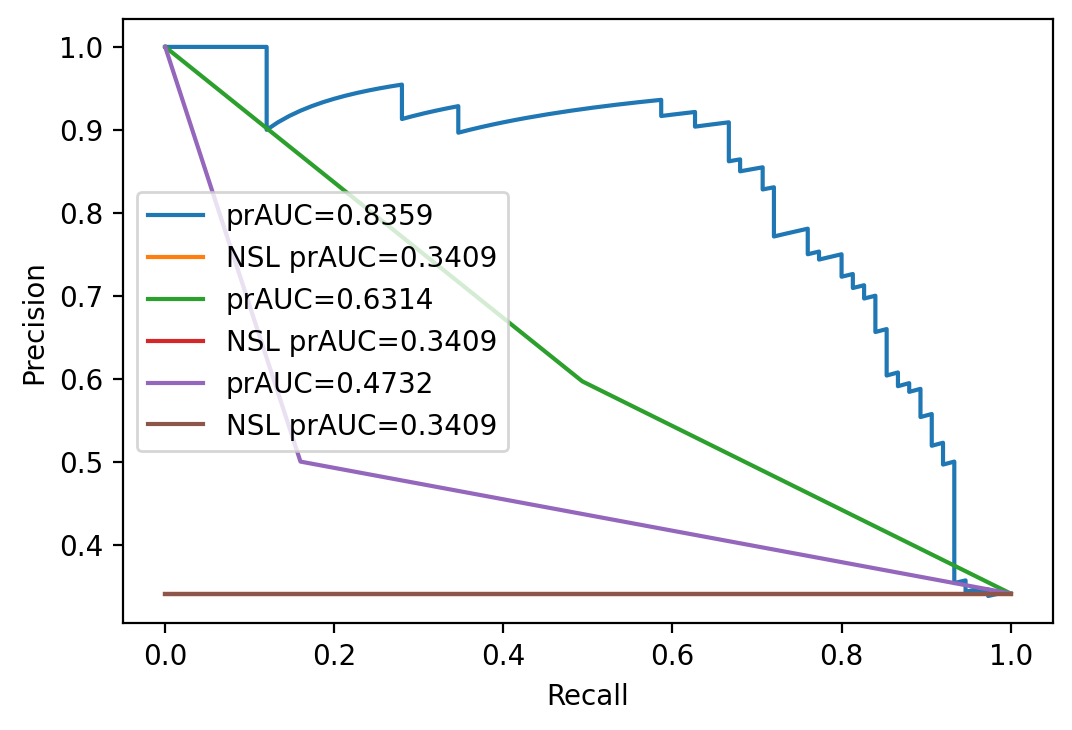

In [72]:
def makePRCPlot(pred,true,noSkill=True):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label="prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

true = []
pred = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    if index in order:
        pred.append(peak_scores.at[index,rawDataDir+file])
        true.append(row["classification"])

makePRCPlot(pred,true)
makePRCPlot(pred_neatms_tl,true_neatms_tl)
makePRCPlot(pred_neatms,true_neatms)
